https://towardsdatascience.com/what-is-the-c4-5-algorithm-and-how-does-it-work-2b971a9e7db0

In [49]:
#!pip install ipywidgets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from colorsetup import colors, palette

In [3]:
gcr_data = pd.read_csv("german_credit_data.csv", index_col=0)

<AxesSubplot:>

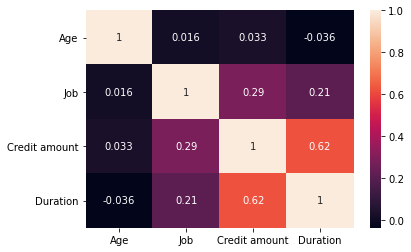

In [4]:
sns.heatmap(gcr_data.corr(), annot=True)

In [5]:
y = (gcr_data['Risk']=='good').astype(int)
correlations = gcr_data[list(gcr_data.columns[:-1])].corrwith(y)
correlations.sort_values(inplace=True)
correlations

Duration        -0.214927
Credit amount   -0.154739
Job             -0.032735
Age              0.091127
dtype: float64

In [6]:
gcr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [7]:
gcr_data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

In [8]:
from sklearn.impute import SimpleImputer
values = gcr_data.values 
imputer = SimpleImputer(missing_values= np.nan, strategy='constant', fill_value='missing') 
transformed_values = imputer.fit_transform(values) 

# strategy can be changed to "median" and “most_frequent”

In [9]:
gcr_data_imputed = pd.DataFrame(transformed_values, columns=gcr_data.columns)

In [10]:
gcr_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   object
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   object
 7   Duration          1000 non-null   object
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: object(10)
memory usage: 78.2+ KB


In [11]:
gcr_data_imputed["Credit amount"] = gcr_data_imputed["Credit amount"].astype(int)
gcr_data_imputed["Duration"] = gcr_data_imputed["Duration"].astype(int)
gcr_data_imputed["Job"] = gcr_data_imputed["Job"].astype(int)
gcr_data_imputed["Age"] = gcr_data_imputed["Age"].astype(int)

<AxesSubplot:>

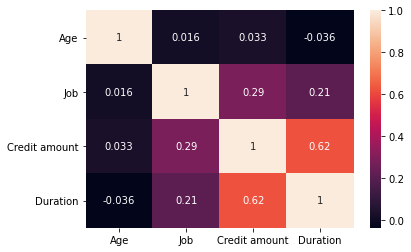

In [12]:
sns.heatmap(gcr_data_imputed.corr(), annot=True)

In [13]:
corr_values = gcr_data_imputed[list(gcr_data_imputed.columns[:-1])].corr()

tril_index = np.tril_indices_from(corr_values)
#display(tril_index)

for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN

corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.6')

,feature1,feature2,correlation,abs_correlation
5,Credit amount,Duration,0.624984,0.624984


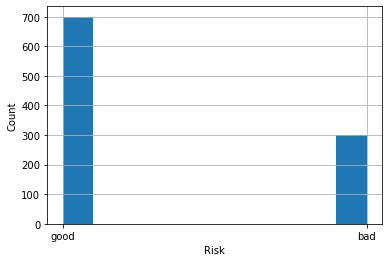

In [14]:
plt.figure()
gcr_data_imputed["Risk"].hist()
plt.xlabel("Risk")
plt.ylabel("Count")
plt.show()

In [15]:
X = gcr_data_imputed.drop(columns='Risk', axis=1)
y = gcr_data_imputed['Risk']

In [16]:
cat_cols = X.columns[X.dtypes == 'O']
num_cols = X.columns[X.dtypes == 'int']

In [17]:
cat_cols

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], dtype='object')

In [18]:
num_cols

Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Job'}>],
       [<AxesSubplot:title={'center':'Credit amount'}>,
        <AxesSubplot:title={'center':'Duration'}>]], dtype=object)

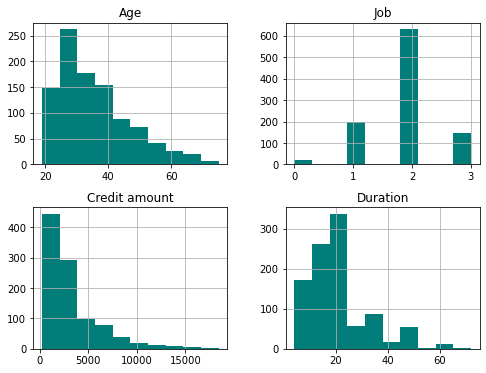

In [19]:
X[num_cols].hist(color=colors[1], figsize=(8, 6))

In [20]:
skew_vals = X[num_cols].skew()
skew_vals

Age              1.020739
Job             -0.374295
Credit amount    1.949628
Duration         1.094184
dtype: float64

In [21]:
skew_limit = 0.75
skew_cols = (skew_vals.
            sort_values(ascending=False)
            .to_frame()
            .rename(columns={0:'Skew'})
            .query('abs(Skew) > {}'.format(skew_limit)))
skew_cols

,Skew
Credit amount,1.949628
Duration,1.094184
Age,1.020739


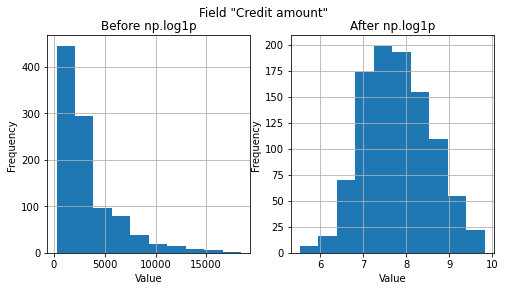

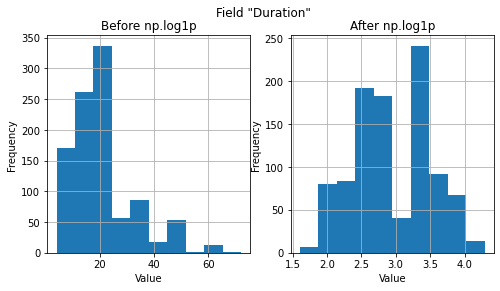

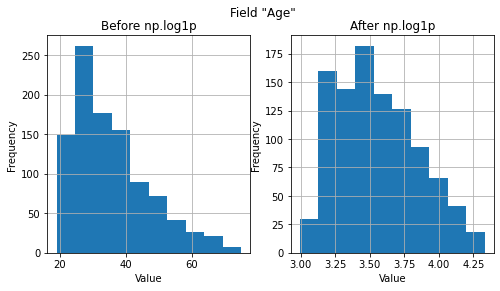

In [22]:
for col in skew_cols.index.values:
    fig, (ax_bef, ax_aft) = plt.subplots(1,2, figsize=(8,4))
    X[col].hist(ax=ax_bef)
    X[col].apply(np.log1p).hist(ax=ax_aft)
    ax_bef.set(title='Before np.log1p', ylabel='Frequency', xlabel='Value')
    ax_aft.set(title='After np.log1p', ylabel='Frequency', xlabel='Value')
    fig.suptitle('Field "{}"'.format(col));

In [23]:
X[col] = X[col].apply(np.log1p)

In [24]:
categories = [
    X[column].unique() for column in X[cat_cols]]
categories

[array(['male', 'female'], dtype=object),
 array(['own', 'free', 'rent'], dtype=object),
 array(['missing', 'little', 'quite rich', 'rich', 'moderate'],
       dtype=object),
 array(['little', 'moderate', 'missing', 'rich'], dtype=object),
 array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
        'domestic appliances', 'repairs', 'vacation/others'], dtype=object)]

In [25]:
for col in cat_cols:
    print('{}: {} {}'.format(col, '\n', X[col].unique()))

Sex: 
 ['male' 'female']
Housing: 
 ['own' 'free' 'rent']
Saving accounts: 
 ['missing' 'little' 'quite rich' 'rich' 'moderate']
Checking account: 
 ['little' 'moderate' 'missing' 'rich']
Purpose: 
 ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [27]:
for column in cat_cols:
    X[column] = le.fit_transform(X[column])

In [28]:
le_tar = LabelEncoder()
gcr_data_imputed['Risk'] = le_tar.fit_transform(gcr_data_imputed['Risk'])

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into two parts with 1500 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=250, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(X, y))

# Create the data sets
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data_imputed.loc[train_idx, 'Risk']

X_test = X.loc[test_idx, X.columns]
y_test = gcr_data_imputed.loc[test_idx, 'Risk']

In [30]:
y_train.value_counts(normalize=True)

1    0.7
0    0.3
Name: Risk, dtype: float64

In [31]:
y_test.value_counts(normalize=True)

1    0.7
0    0.3
Name: Risk, dtype: float64

In [32]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here

# oob_score > Whether to use out-of-bag samples to estimate the generalization accuracy.
# warm_start > When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
# n_jobs > The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 

RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
15.0,0.341333
20.0,0.322667
30.0,0.310667
40.0,0.304000
50.0,0.297333
100.0,0.273333
150.0,0.268000
200.0,0.265333
300.0,0.277333


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

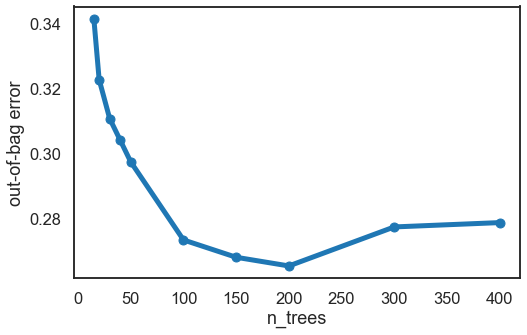

In [35]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(8, 5), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [36]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here

# bootstrap > Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

,oob
n_trees,
15.0,0.309333
20.0,0.298667
30.0,0.294667
40.0,0.305333
50.0,0.313333
100.0,0.293333
150.0,0.289333
200.0,0.288000
300.0,0.288000


In [37]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

oob_df

,RandomForest,ExtraTrees
n_trees,,
15.0,0.341333,0.309333
20.0,0.322667,0.298667
30.0,0.310667,0.294667
40.0,0.304000,0.305333
50.0,0.297333,0.313333
100.0,0.273333,0.293333
150.0,0.268000,0.289333
200.0,0.265333,0.288000
300.0,0.277333,0.288000


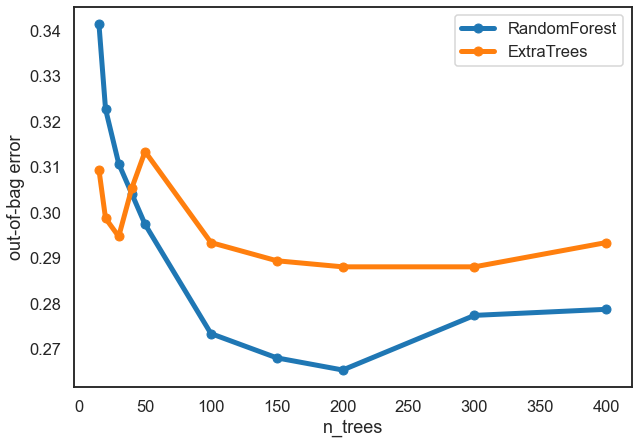

In [38]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(marker='o', figsize=(10, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [39]:
# Random forest with 100 estimators
model = RF.set_params(n_estimators=100)

y_pred = model.predict(X_test)

In [40]:
y_prob = model.predict_proba(X_test)

In [41]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

display(score_df)

# 0 > Bad
# 1 > Good

              precision    recall  f1-score   support

           0       0.66      0.41      0.51        75
           1       0.78      0.91      0.84       175

    accuracy                           0.76       250
   macro avg       0.72      0.66      0.67       250
weighted avg       0.75      0.76      0.74       250



,accuracy,precision,recall,f1,auc
0,0.76,0.783251,0.908571,0.84127,0.660952


Text(0.5, 40.5, 'Ground Truth')

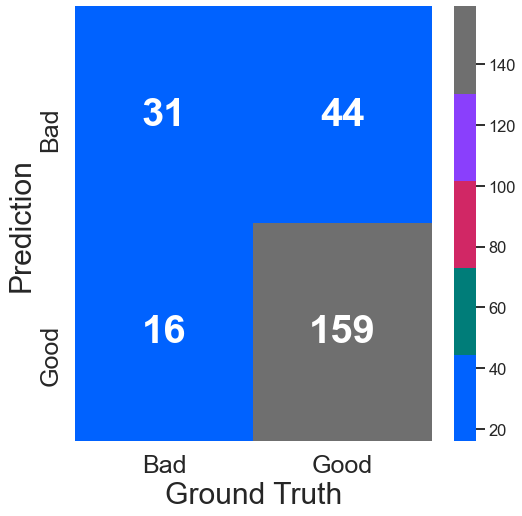

In [42]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=colors, annot_kws={"size": 40, "weight": "bold"})

labels = ['Bad', 'Good']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels, fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

# FPR = 16/(16+31) = 34%

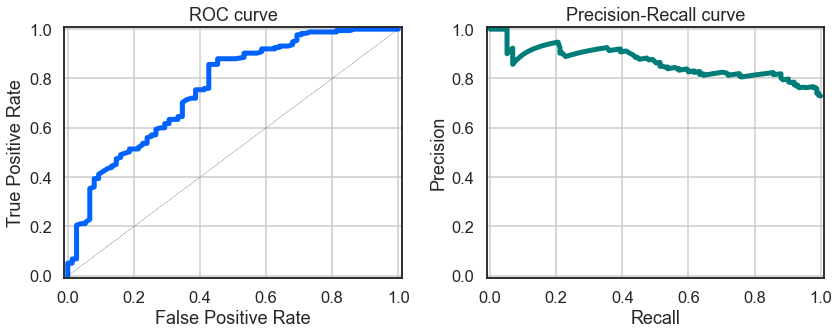

In [43]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, color=colors[0], linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, color=colors[1], linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

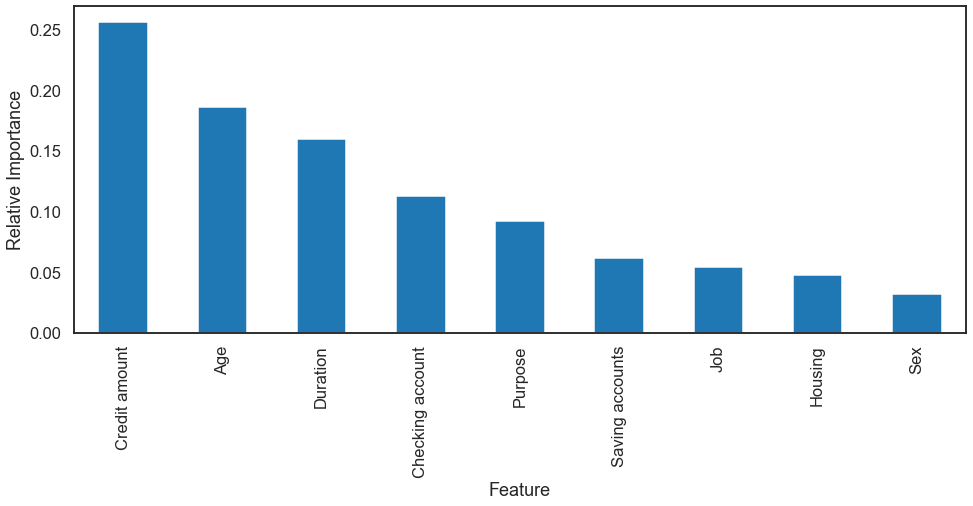

In [45]:
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance');
ax.set(xlabel='Feature');

In [47]:
import nbinteract as nbi
nbi.publish('Rohit9Kharat/nbinteract-image/master', 'GCR_Bagging.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... 

Converting notebook...



Successfully converted!

<a href="GCR_Bagging.html" target="_blank" download>Click to download your webpage.</a>

To host your webpage, see the documentation:
<a href="https://www.nbinteract.com/tutorial/tutorial_publishing.html"
        target="_blank">
    https://www.nbinteract.com/tutorial/tutorial_publishing.html
</a>
